# Part III - B: Analyzing Changing Trends in Academia - Author Trends

## 2. Author Dynamics

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In this notebook, we are going to explore how authors' behaviors and characteristics have changed over the last two centuries. First, let's load all the required packages and add some helpful draw functions.In this notebook, we are going to explore how authors' behaviors and characteristics have changed over the last two centuries. First, let's load all the required packages and add some helpful draw functions.

In [4]:
from ScienceDynamics.config.configs import *
import pandas as pd
import numpy as np
import altair as alt
from vega_datasets import data
# alt.renderers.enable('notebook')

from ScienceDynamics.visualization.visual_utils import *
import turicreate.aggregate as agg

def normalize_features_dict(feature_dict, start_year):
    d = {}
    feature_dict = {(y - start_year):v for y,v in feature_dict.iteritems()}
    return feature_dict

def get_values_sum_by_year_dict(d, max_keys):
    d2 = {}
    for i in range(max_keys):
        d2[i] = sum([v for k,v in d.iteritems() if k <= i])
    return d2 

#some help function to draw the decade graph
def draw_decades_avg_chart(sf, col_name, avg_col_name, max_year=2014, title=None):
    sf = sf[sf["Years since First Publication"] != None]
    sf = sf[sf[col_name] != None]
    sf = sf[sf.apply(lambda r: (r["Academic BirthYear"] + r["Years since First Publication"])<= max_year)]
    g = sf.groupby(["Academic Birth Decade",  "Years since First Publication"], {avg_col_name: agg.AVG(col_name)})
    df =g.to_dataframe()
    if title is not None:
        chart = alt.Chart(df, title=title)
    else:
        chart = alt.Chart(df)
    chart = chart.mark_line().encode(
        alt.X('Years since First Publication:Q', axis=alt.Axis(format='d'), scale=alt.Scale(zero=False)),
        alt.Y("%s:Q" % avg_col_name, scale=alt.Scale(zero=False)),
        color="Academic Birth Decade"   )
    return chart

#some help function to draw the decade graph
def draw_decades_med_chart(sf, col_name, med_col_name, max_year=2014, title=None):
    sf = sf[sf["Years since First Publication"] != None]
    sf = sf[sf[col_name] != None]
    sf = sf[sf.apply(lambda r: (r["Academic BirthYear"] + r["Years since First Publication"])<= max_year)]
    g = sf.groupby(["Academic Birth Decade",  "Years since First Publication"], {"Med List": agg.CONCAT(col_name)})
    g[med_col_name] = g["Med List"].apply(lambda l: np.median(l))
    g = g.remove_column('Med List')
    df = g.to_dataframe()
    
    if title is not None:
        chart = alt.Chart(df, title=title)
    else:
        chart = alt.Chart(df)
    chart = chart.mark_line().encode(
        alt.X('Years since First Publication:Q', axis=alt.Axis(format='d'), scale=alt.Scale(zero=False)),
        alt.Y("%s:Q" % med_col_name, scale=alt.Scale(zero=False)),
        color="Academic Birth Decade"   )
    return chart

### 2.1. Number of New Authors םver ime

First, we will start by observing how the number of new authors has changed over the years.

In [5]:
from ScienceDynamics.datasets.microsoft_academic_graph import MicrosoftAcademicGraph
from ScienceDynamics.config.configs import DATASETS_BASE_DIR
mag = MicrosoftAcademicGraph(DATASETS_BASE_DIR / "MicrosoftAcademicGraph.zip")

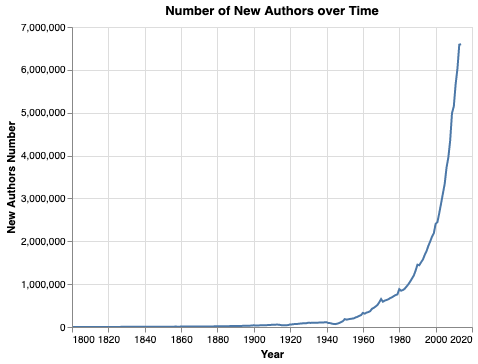

In [6]:


p_sf = mag.extended_papers["Paper ID", "Paper publish year"]
a_sf = mag.paper_author_affiliations["Paper ID", "Author ID"]
sf = a_sf.join(p_sf)["Author ID",  "Paper publish year"]
sf = sf.rename({"Paper publish year": "Year"})
g = sf.groupby("Author ID", {"Start Year": agg.MIN("Year")}) # Create the starting year of 114,692,920 authors
g2 = g.groupby("Start Year", {"New Authors Number": agg.COUNT()})
g2 = g2.rename({"Start Year": "Year"})
draw_features_yearly_chart(g2, "New Authors Number", 1800, 2014, title="Number of New Authors over Time")

It can be observed that over the years there has been a surge in the number of new authors. Next, let us examine how various authors' features have changed over time. To achieve this, in the rest of this notebook we will mainly see the AUTHORS_FEATURES_SFRAME, which contains various other features of over 20 million authors who published at least one paper with 5 references (see [notebook]()). Let's utilize the AUTHORS_FEATURES_SFRAME and the authors' first names that will be used to predict authors’ genders and to observe trends of new authors' genders.

In [3]:
af_sf = tc.load_sframe(AUTHROS_FEATURES_SFRAME)
af_sf["Academic BirthYear"] =  af_sf["Papers by Years Dict"].apply(lambda d: min(d.keys()))
af_sf["Predicted Gender"] = af_sf["Gender Dict"].apply(lambda d: d["Gender"])
af_sf["Academic Birth Decade"] = af_sf["Academic BirthYear"].apply(lambda y: y - y%10)
sf = af_sf["Academic BirthYear", "Predicted Gender"]
g = sf.groupby(["Academic BirthYear", "Predicted Gender"], {"New Authors Number": agg.COUNT()}) 
g = g.rename({"Academic BirthYear": "Year"})
g = filter_sframe_by_years(g, 1800, 2014)
g = g[g["Predicted Gender"].apply(lambda n: n in {"Male", "Female"})]

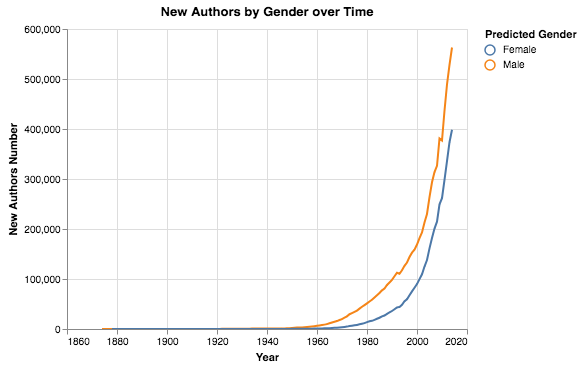

In [4]:
chart = alt.Chart(g.to_dataframe(),title="New Authors by Gender over Time").mark_line().encode(
    alt.X('Year:Q', axis=alt.Axis(format='d'), scale=alt.Scale(zero=False)),
    alt.Y('New Authors Number:Q' , scale=alt.Scale(zero=False)),
    color="Predicted Gender"    )
chart

From the above chart we can see that there is an increase in both male and female new authors.

### 2.2 Authors' Number of Papers over Time

Let's use the MAG dataset to observe how the average number of authors per paper has changed over the decades.

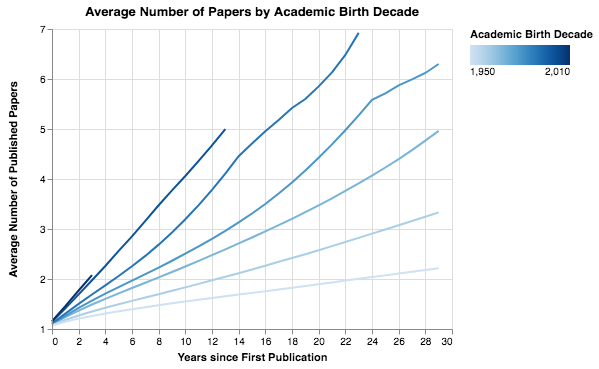

In [5]:
selected_decades = {1950,1960,1970,1980, 1990, 2000, 2010}


sf = af_sf["Papers by Years Dict", "Academic BirthYear", "Academic Birth Decade"]    
sf = sf[sf["Academic Birth Decade"].apply(lambda decade: decade in selected_decades)]

# First, for each author, we create a dict in which each key is the number of years since the author published his/her first paper, and the 
# the number of papers the author wrote in a specific year since the publication of his/her first paper
sf["Papers Number by Years Dict"] = sf["Papers by Years Dict"].apply(lambda d:{k:len(v) for k,v in d.iteritems()})
sf["Papers Number by Years Dict"] = sf.apply(lambda r: normalize_features_dict(r["Papers Number by Years Dict"], r["Academic BirthYear"]))

# Second, for each author, we create a dict with the total number of papers the author have written after 'n' years
# since he/she published his/her first paper
sf["Total Papers Dict"] = sf.apply(lambda r: get_values_sum_by_year_dict(r["Papers Number by Years Dict"], 
                                                                         min(30, 2014 - r["Academic BirthYear"])))

sf = sf["Academic Birth Decade","Academic BirthYear", "Total Papers Dict"]
t_sf = sf.stack("Total Papers Dict", new_column_name=["Years since First Publication", "Total Papers Number"])
draw_decades_avg_chart(t_sf, "Total Papers Number","Average Number of Published Papers", title="Average Number of Papers by Academic Birth Decade" )

Let's redraw the chart, only this time using only authors that published at least 5 papers during all their career.

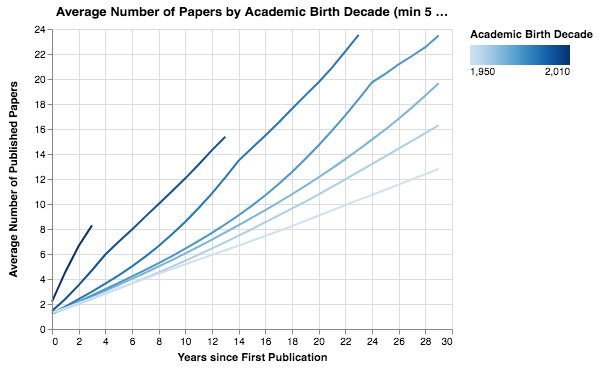

In [6]:
sf["Total Papers"] = sf["Total Papers Dict"].apply(lambda d: d[max(d.keys())] if d is not None and len(d.keys()) > 0 else None)
sf = sf[sf["Total Papers"] >= 5]            
t_sf = sf.stack("Total Papers Dict", new_column_name=["Years since First Publication", "Total Papers Number"])
draw_decades_avg_chart(t_sf, "Total Papers Number","Average Number of Published Papers", title="Average Number of Papers by Academic Birth Decade (min 5 papers)" )                                       

As can be observed from the above graph, in each decade the rate of publications by new researchers considerably accelerated. For example, researchers who started their academic career in the 1960s published on average a little less than 2 papers after a decade. However, researchers that started their career in the 2000s published on average about 2 papers after less than 4 years, and about 12 papers after a decade.

### 2.3 Authors’ Publications in Venues over Time

Let's use the data to observe authors' trends in publishing in conferences and journals

In [7]:
af_sf["Academic BirthYear"] =  af_sf["Papers by Years Dict"].apply(lambda d: min(d.keys()))
af_sf["Predicted Gender"] = af_sf["Gender Dict"].apply(lambda d: d["Gender"])
af_sf["Academic Birth Decade"] = af_sf["Academic BirthYear"].apply(lambda y: y - y%10)


def is_empty_venue_list(l):
    l = [i for i in l if i != '']
    if len(l) == 0:
        return True
    return False
selected_decades = {1950,1970, 1990, 2000, 2010}        
sf = af_sf["Academic BirthYear", "Academic Birth Decade", 'Conference ID by Year Dict', 'Journal ID by Year Dict']
sf['Number of Conference by Year Dict'] = sf['Conference ID by Year Dict'].apply(lambda d:{k:len(v) for k,v in d.iteritems() if not is_empty_venue_list(v) })
sf['Number of Journals ID by Year Dict'] = sf['Journal ID by Year Dict'].apply(lambda d:{k:len(v) for k,v in d.iteritems() if not is_empty_venue_list(v)})
sf['Number of Conference by Year Dict'] = sf.apply(lambda r: normalize_features_dict(r['Number of Conference by Year Dict'], r['Academic BirthYear']))
sf['Number of Journals by Year Dict'] = sf.apply(lambda r: normalize_features_dict(r['Number of Journals ID by Year Dict'], r['Academic BirthYear']))
sf = sf[sf["Academic Birth Decade"].apply(lambda decade: decade in selected_decades)]
sf.materialize()

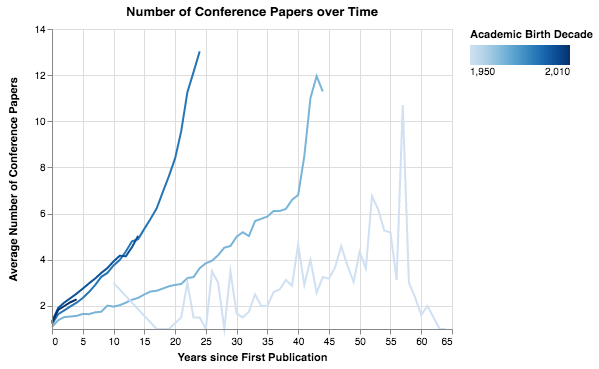

In [8]:
c_sf= sf["Academic BirthYear","Academic Birth Decade",'Number of Conference by Year Dict']
c_sf = c_sf[c_sf['Number of Conference by Year Dict'] != {}]
c_sf = c_sf.stack("Number of Conference by Year Dict", new_column_name=["Years since First Publication", "Total Number of Conferences"])
draw_decades_avg_chart(c_sf, 'Total Number of Conferences',"Average Number of Conference Papers", title="Number of Conference Papers over Time" )

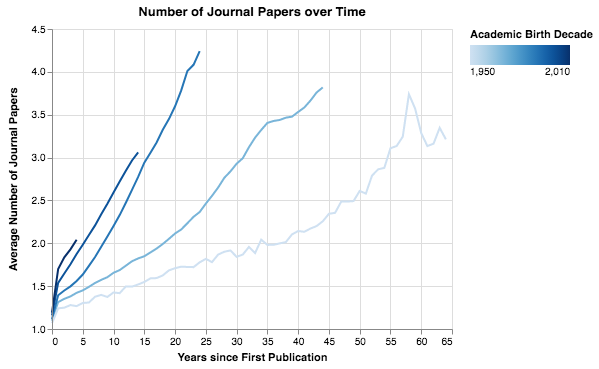

In [9]:
j_sf= sf["Academic BirthYear","Academic Birth Decade",'Number of Journals by Year Dict']
j_sf = j_sf[j_sf['Number of Journals by Year Dict'] != {}] 
j_sf = j_sf.stack("Number of Journals by Year Dict", new_column_name=["Years since First Publication", "Total Number of Journals"])
draw_decades_avg_chart(j_sf, 'Total Number of Journals',"Average Number of Journal Papers", title="Number of Journal Papers over Time"  )

We can observe that with each decade, researchers publish more and more journal and conferences papers. Moreover, we can observe that since the 1990s there has been a trend to publish more and more papers in conferences. For example, while researchers that started their careers in the 1970s published on average about 2 conference papers and 1.65 journal papers after 10 years, researchers that started their career in the 2000s published about 4 conference papers and 2.59 journal papers.

### 2.4 Number of Coauthors over Time

Now let's calculate the average number of coauthors over time for an authors’ group that started their careers in the same decade.

2018-07-20 18:09:33,342 [MainThread  ] [DEBUG]  Fetching author 00001F05
2018-07-20 18:09:33,353 [MainThread  ] [DEBUG]  Fetching author 00002AD3
2018-07-20 18:09:33,355 [MainThread  ] [DEBUG]  Fetching author 00006A31
2018-07-20 18:09:33,357 [MainThread  ] [DEBUG]  Fetching author 0000B5FA
2018-07-20 18:09:33,361 [MainThread  ] [DEBUG]  Fetching author 0001CF9B
2018-07-20 18:09:33,363 [MainThread  ] [DEBUG]  Fetching author 00040294
2018-07-20 18:09:33,366 [MainThread  ] [DEBUG]  Fetching author 0004B8AF
2018-07-20 18:09:33,368 [MainThread  ] [DEBUG]  Fetching author 000510E2
2018-07-20 18:09:33,370 [MainThread  ] [DEBUG]  Fetching author 00063841
2018-07-20 18:09:33,372 [MainThread  ] [DEBUG]  Fetching author 00065272
2018-07-20 18:09:33,374 [MainThread  ] [DEBUG]  Fetching author 0006F3CE
2018-07-20 18:09:33,376 [MainThread  ] [DEBUG]  Fetching author 000757F8
2018-07-20 18:09:33,379 [MainThread  ] [DEBUG]  Fetching author 00079EC2
2018-07-20 18:09:33,381 [MainThread  ] [DEBUG]  Fet

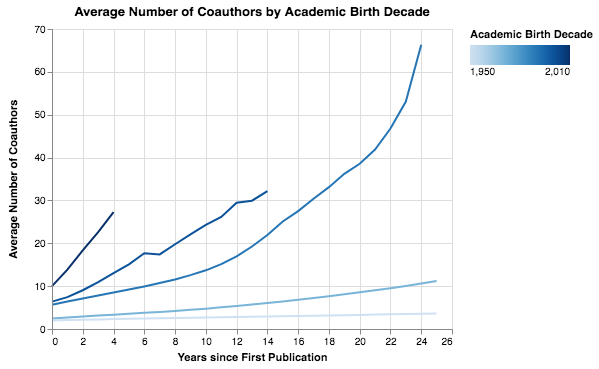

In [10]:
from author import Author

def get_total_coauthors_number_by_year_dict(author_id, year_span=25, max_year=2014):
    a = Author(author_id)    
    start_year = a.first_publication_year
    last_year = min(start_year + year_span, max_year)
    try:
        coauthors = a.get_coauthors_list(start_year, last_year)
    except:
        return None

    return {(i - start_year):len(set(a.get_coauthors_list(start_year,i))) for i in range(start_year, last_year + 1)}

selected_decades = {1950,1970, 1990, 2000, 2010}
af_sf = tc.load_sframe(AUTHROS_FEATURES_SFRAME)
af_sf["Academic BirthYear"] =  af_sf["Papers by Years Dict"].apply(lambda d: min(d.keys()))
af_sf["Predicted Gender"] = af_sf["Gender Dict"].apply(lambda d: d["Gender"])
af_sf["Academic Birth Decade"] = af_sf["Academic BirthYear"].apply(lambda y: y - y%10)
sf = af_sf["Author ID", "Coauthors by Years Dict", "Academic BirthYear", "Academic Birth Decade", "Predicted Gender"]  
sf = sf[sf["Academic Birth Decade"].apply(lambda decade: decade in selected_decades)]
sf['Total Coauthors Dict'] = sf["Author ID"].apply(lambda i: get_total_coauthors_number_by_year_dict(i))
sf.materialize()
a_sf = sf.stack("Total Coauthors Dict", new_column_name=["Years since First Publication", "Total Coauthors Number"])
draw_decades_avg_chart(a_sf, "Total Coauthors Number","Average Number of Coauthors", title="Average Number of Coauthors by Academic Birth Decade" )

We can observe that the average number of coauthors considerably increased over the decades. Moreover, we can notice that while authors that started their careers in the 1950s and 1970s had on average only a few coauthors over a period of 25 years, researchers who started their careers in the 1990s had over 60 coauthors in the same career length of 25 years.

### 2.5  Authors’ Place in Authors List over Time

In this section, let's check the average/median place of authors in the papers' authors list based on the decade the authors published their first paper. Moreover, we will examine how the average number of times for authors to be a first author is based on the decade the authors' started their career and on their gender.

In [11]:
selected_decades = {1950,1970, 1990, 2000, 2010} 
sf = af_sf['Academic Birth Decade', 'Academic BirthYear', 'Sequence Number by Year Dict', 'Predicted Gender']
sf = sf[sf["Academic Birth Decade"].apply(lambda decade: decade in selected_decades)]
sf["Papers Number by Years Dict"] = sf.apply(lambda r: normalize_features_dict(r['Sequence Number by Year Dict'], r["Academic BirthYear"]))
s_sf = sf.stack("Papers Number by Years Dict", new_column_name=["Years since First Publication", "Sequence Number List"])
s_sf = s_sf.stack("Sequence Number List", new_column_name="Sequence Number")


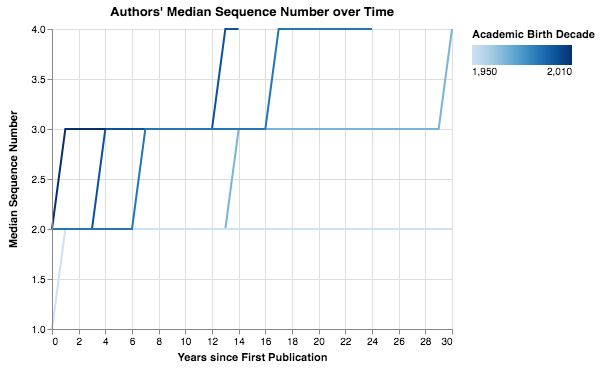

In [12]:
sf = s_sf[ 'Academic BirthYear', "Academic Birth Decade","Years since First Publication", "Sequence Number",'Predicted Gender']
sf = sf[sf["Years since First Publication"] != None]
sf = sf[sf["Sequence Number"] != None]
sf = sf[sf["Years since First Publication"] <= 30]
draw_decades_med_chart(sf,"Sequence Number", "Median Sequence Number", title="Authors' Median Sequence Number over Time" )

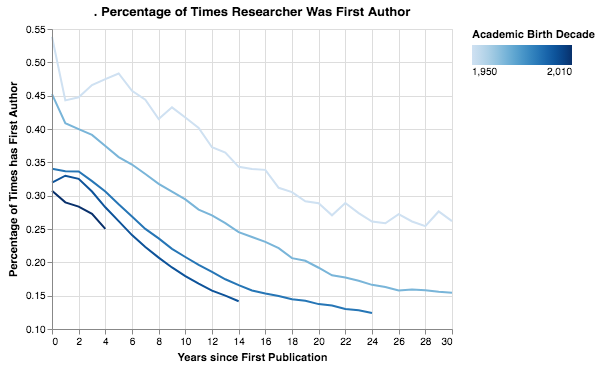

In [13]:
sf["Is First Author"] = sf["Sequence Number"].apply(lambda i: 1 if i == 1 else 0)
draw_decades_avg_chart(sf,"Is First Author", "Percentage of Times has First Author", title=". Percentage of Times Researcher Was First Author"  )


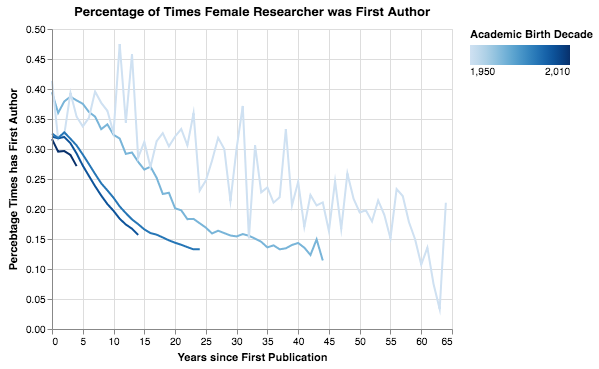

In [14]:
sf = s_sf[ 'Academic BirthYear', "Academic Birth Decade","Years since First Publication", "Sequence Number",'Predicted Gender']
sf["Is First Author"] = sf["Sequence Number"].apply(lambda i: 1 if i == 1 else 0)
sf = sf[sf["Predicted Gender"] == "Female"]
draw_decades_avg_chart(sf,"Is First Author", "Percebtage Times has First Author",  title="Percentage of Times Female Researcher was First Author" )

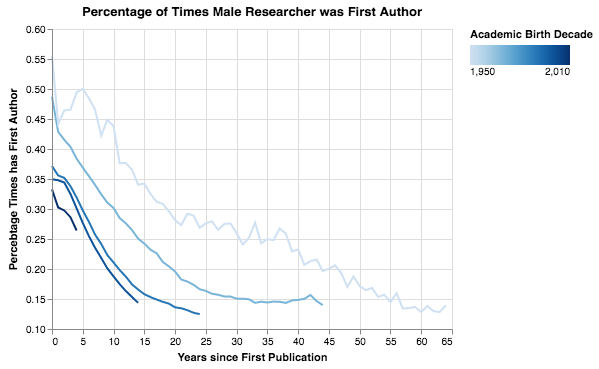

In [15]:
sf = s_sf[ 'Academic BirthYear', "Academic Birth Decade","Years since First Publication", "Sequence Number",'Predicted Gender']
sf["Is First Author"] = sf["Sequence Number"].apply(lambda i: 1 if i == 1 else 0)
sf = sf[sf["Predicted Gender"] == "Male"]
draw_decades_avg_chart(sf,"Is First Author", "Percebtage Times has First Author", title="Percentage of Times Male Researcher was First Author" )

It can be observed that as time passes, the percentage of senior authors being a first author decreases.

In [16]:
sf = s_sf[ 'Academic BirthYear', "Academic Birth Decade","Years since First Publication","Sequence Number",'Predicted Gender']
sf["Is First Author"] = sf["Sequence Number"].apply(lambda i: 1 if i == 1 else 0)
g = sf.groupby(["Academic Birth Decade","Years since First Publication",'Predicted Gender'], {"Percebtage Times has First Author":agg.AVG("Is First Author")})
g = g.rename({'Predicted Gender':"Gender"})
g = g[g["Gender"].apply(lambda gender: gender in {"Male", "Female"})]
g = g.sort(["Academic Birth Decade","Years since First Publication" ])

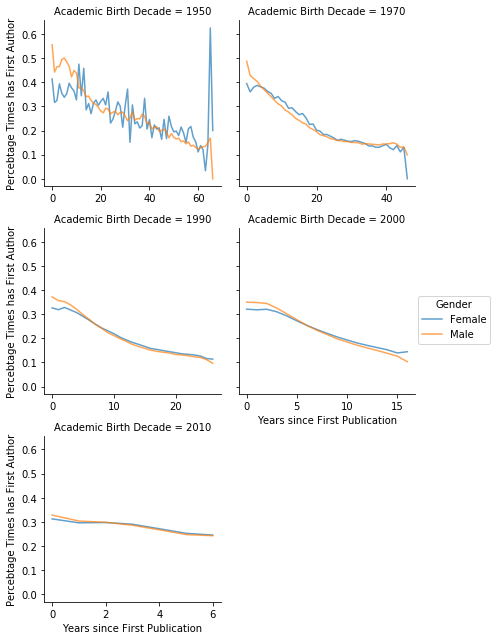

In [17]:
c = sns.FacetGrid(g.to_dataframe(), col="Academic Birth Decade", hue='Gender', sharex=False, sharey=True, col_wrap=2)
c.map(plt.plot, "Years since First Publication", "Percebtage Times has First Author", alpha=.7)
c.add_legend()

We notice that over the decades, the gap between the number of times a male and female are, on average, first authors considerably decreases.